# Introducción al MEF en una dimensión

*Alejandro Alonso Membrilla* y *Pilar Navarro Ramírez*

**Ejercicio (optativo):** Estudiar y/o implementar también el código correspondiente a la resolución numérica aproximada de un problema autoadjunto general

$$\mathcal{L}(y)\equiv -(p(x)y')'+q(x)y= f(x), \; x\in [a,b]$$

para cierta función $f(x)$ continua en dicho intervalo, (con funciones $p\in\mathcal{C}^1$ y $q\in\mathcal{C}^0$) y con diferentes condiciones de contorno de tipo Dirichlet, Neumann y/o Robin, en cada uno de los extremos del intervalo.

In [1]:
import numpy as np # Importamos el módulo NumPy con el pseudónimo np
import sympy as sp # Importamos el módulo SymPy con el pseudónimo sp
import math
%matplotlib inline 
import matplotlib.pyplot as plt

### Definición de los E.F. y de las funciones base:

In [2]:
def l1(t):
    """primera func. de base del E.F. de Lagrange P1 en 1D"""
    return 1-t

def l2(t):
    """segunda func. de base del E.F. de Lagrange P1 en 1D"""
    return t

def dl1(t):
    """derivada de la primera func. de base del E.F. de Lagrange P1 en 1D"""
    return -1

def dl2(t):
    """derivada de la segunda func. de base del E.F. de Lagrange P1 en 1D"""
    return 1

def Finv(z,a,b):
    """afinidad entre cada subintervalo de la partición 
        y el intervalo unidad"""
    return (z-a)/(b-a)

def dFinv(z,a,b):
    """ derivada de la afinidad Finv"""
    return 1/(b-a)

In [3]:
def wi(z,x,i):  # en los nodos interiores
    """funciones de base del E.F. de Lagrange P1 unidimensional"""
    if (x[i-1]<=z)*(z<=x[i]):
        valor = l2(Finv(z,x[i-1],x[i]))
    elif (x[i]<=z)*(z<=x[i+1]):  
        valor = l1(Finv(z,x[i],x[i+1]))
    else:
        valor = 0
    return valor

def w0(z,x):  # en el extremo izquierdo del intervalo
    """funcion de base del E.F. de Lagrange P1 unidimensional 
    en el extremo izquierdo"""
    if (x[0]<=z)*(z<=x[1]):
        valor = l1(Finv(z,x[0],x[1]))
    else:
        valor = 0
    return valor

def wn(z,x):  # en el extremo derecho del intervalo
    """funcion de base del E.F. de Lagrange P1 unidimensional 
    en el extremo derecho"""
    # recuérdese que x[-1] y x[-2] indican respectivamente el último y penúltimo nodos
    if (x[-2]<=z)*(z<=x[-1]):  
        valor = l2(Finv(z,x[-2],x[-1])) 
    else:
        valor = 0
    return valor

### Definición del problema:

In [4]:
z = sp.Symbol('z')
y = sp.Function('y')
p = sp.Function('p')
q = sp.Function('q')
def L(y,z,p,q): # usaremos la variable z como variable independiente
    """operador diferencial que define la ec. dif."""
    return -sp.diff(p(z)*sp.diff(y(z),z,1), z, 1)+q(z)*y(z)
L(y,z,p,q)  

-p(z)*Derivative(y(z), (z, 2)) + q(z)*y(z) - Derivative(p(z), z)*Derivative(y(z), z)

In [5]:
f = sp.Function('f')

def ecuacion(y,z,p,q,f):
    return sp.Eq(L(y,z,p,q),f(z)) #  ec. diferencial que estamos considerando 

ecuacion(y,z,p,q,f)

Eq(-p(z)*Derivative(y(z), (z, 2)) + q(z)*y(z) - Derivative(p(z), z)*Derivative(y(z), z), f(z))

### Resolución del Problema:

In [6]:
nx= 50;  # número de subintervalos de igual longitud a considerar
a = 0; b = 10; # intervalo de trabajo
x = np.linspace(a,b,nx+1)  # partición

In [7]:
#matriz local
xL, xR = sp.symbols('xL,xR')
a00 = sp.integrate((dl1(Finv(z,xL,xR))*dFinv(z,xL,xR))**2,[z,xL,xR])
a01 = sp.integrate(dl1(Finv(z,xL,xR))*dl2(Finv(z,xL,xR))*dFinv(z,xL,xR)**2,[z,xL,xR])
a11 = sp.integrate((dl2(Finv(z,xL,xR))*dFinv(z,xL,xR))**2,[z,xL,xR])

Agen = sp.Matrix([[a00,a01],[a01,a11]])
Agen = sp.simplify(Agen)

h_e = sp.Symbol('h_e') 
Agen = Agen.subs({xL-xR:-h_e, -xL+xR:h_e})

In [8]:
def matriz_global(nx, problema='dirichlet'):
    size = nx-1 if problema=='dirichlet' else nx
    A = np.zeros((size,size),dtype=float)
    
    ret = 1 if problema=='neumann_izquierda' else 0
    n_diag_sup = nx-1 if problema=='dirichlet' else nx
    for i in range(1+ret,nx+ret): 
        A[i-1,i-1] = Agen[1,1].subs({h_e:x[i-ret]-x[i-1-ret]})+Agen[0,0].subs({h_e:x[i+1-ret]-x[i-ret]})
    for i in range(1,n_diag_sup): # y ahora la diagonal inferior adyacente
        A[i-1,i] = Agen[0,1].subs({h_e:x[i+1-ret]-x[i-ret]})
        A[i,i-1] = A[i-1,i] # aprovechando la simetría de la matriz
    if problema=='neumann_derecha':
        A[nx-1,nx-1]   = Agen[1,1].subs({h_e:x[nx-ret]-x[nx-1-ret]})
    elif problema=='neumann_izquierda':
        A[0,0]   = Agen[0,0].subs({h_e:x[1]-x[0]})
    return A

In [9]:
from scipy.integrate import quad

def fbis(f, z, p1, p, q): # permite considerar condiciones de frontera homogéneas
    t = sp.Symbol('t')
    return (f(t)-L(p1,t,p,q)).subs({t:z})
    #return (f(t)-L(lambda x:p1.subs(z,x),t,p,q)).subs({t:z})


def vector_cargas(nx, p1, f, p, q, problema):
    size = nx-1 if problema=='dirichlet' else nx 
    B = np.zeros(size)
    
    ret = 1 if problema=='neumann_izquierda' else 0
    for i in range(1+ret,nx+ret):
        intizda = quad(lambda z:fbis(f,z,p1,p,q)*l2(Finv(z,x[i-1-ret],x[i-ret])),x[i-1-ret],x[i-ret])
        intdcha = quad(lambda z:fbis(f,z,p1,p,q)*l1(Finv(z,x[i-ret],x[i+1-ret])),x[i-ret],x[i+1-ret])
        B[i-1] = intizda[0] + intdcha[0]
    if problema=='neumann_derecha':
        B[nx-1] = quad(lambda z:fbis(f,z,p1,p,q)*l2(Finv(z,x[nx-1],x[nx])),x[nx-1],x[nx])[0]
    elif problema=='neumann_izquierda':
        B[0] = quad(lambda z:fbis(f,z,p1,p,q)*l1(Finv(z,x[0],x[1])),x[0],x[1])[0]
    return B

In [10]:
## res es la resolución (número de nodos) del vector que se devuelve (igual que el dibujo),
# el número de nodos usados internamente para el cálculo de la solución es nx.
## plot indica si se desea mostrar un gráfico con la solución calculada.
def resolver_autoadjunto(p,q,f,ya=None,yb=None,dya=None,dyb=None,res=1000,plot=True):
    #assert sum(x is not None for x in [ya,yb,dya,dyb])>=2 ,"Debe haber al menos dos condiciones de contorno."
    assert callable(p) and callable(q) and callable(f), "p, q y f deben ser funciones o lambdas."
    
    # Discernimos entre los casos siguientes
    if ya is not None and yb is not None:    # Se fijan los extremos
        problema = 'dirichlet'
    elif ya is not None and dyb is not None:    # Condición Dirichlet izquierda, Neumann derecha
        problema = 'neumann_derecha'
    elif yb is not None and dya is not None:    # Condición Neumann izquierda, Dirichlet derecha
        problema = 'neumann_izquierda'
    else:
        print("Opción no implementada")
        return
    print("Detectadas condiciones tipo", problema)
    
    A = matriz_global(nx, problema)
    print('\nMatriz de rigidez:\n')
    print(A)
    # Definimos p1, esto es, el polinomio lineal homogeneizador
    z = sp.Symbol('z')
    if problema=='dirichlet':
        p1 = lambda z:ya+(yb-ya)/(b-a)*(z-a)
    elif problema=='neumann_derecha':
        p1 = lambda z:ya+dyb*(z-a)
    elif problema=='neumann_izquierda':
        p1 = lambda z:yb+dya*(z-b)
    
    B = vector_cargas(nx, p1, f, p, q, problema)
    print('\nVector de carga:\n')
    print(B)
    
    Y = np.linalg.solve(A,B)
    
    xx = np.linspace(a,b,res)
    if problema=='dirichlet' or problema=='neumann_derecha':
        yy = np.array([sum([wi(z,x,i)*Y[i-1] for i in range(1,nx)]) for z in xx])
    elif problema=='neumann_izquierda':
        yy = np.array([sum([wi(z,x,i)*Y[i] for i in range(1,nx)]) for z in xx])
        
    if problema=='neumann_derecha':
        yy = yy + Y[-1]*np.array([wn(z,x) for z in xx])
    elif problema=='neumann_izquierda':
        yy = yy + Y[0]*np.array([w0(z,x) for z in xx])
    yyp1 = np.array([p1(x) for x in xx])
    solucion = yy+yyp1
    if plot:
        plt.plot(xx,solucion, label="Solución"); # de contorno del problema de partida
        plt.plot(xx,yy, label="Solución Homogénea");
        plt.plot(xx, yyp1, label="p1");
        plt.legend();
    
    return solucion

Probaremos nuestra función general con los dos problemas (Dirichlet y Neumann) vistos en prácticas.

Detectadas condiciones tipo dirichlet

Matriz de rigidez:

[[10. -5.  0. ...  0.  0.  0.]
 [-5. 10. -5. ...  0.  0.  0.]
 [ 0. -5. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 10. -5.  0.]
 [ 0.  0.  0. ... -5. 10. -5.]
 [ 0.  0.  0. ...  0. -5. 10.]]

Vector de carga:

[ 0.0396016   0.0776244   0.11255257  0.14299362  0.16773396  0.18578729
  0.19643385  0.19924923  0.19412116  0.18125409  0.161161    0.13464293
  0.10275706  0.0667746   0.02813005 -0.01163596 -0.05093809 -0.08820947
 -0.12196422 -0.15085664 -0.17373488 -0.18968686 -0.19807662 -0.1985697
 -0.19114642 -0.17610275 -0.15403841 -0.12583304 -0.09261111 -0.05569707
 -0.01656256  0.02323225  0.06210086  0.0984937   0.13095991  0.15820517
  0.17914328  0.19293951  0.19904386  0.19721296  0.18751979  0.17035081
  0.14639047  0.11659401  0.08214932  0.04442959  0.00493859 -0.03474929
 -0.07305183]


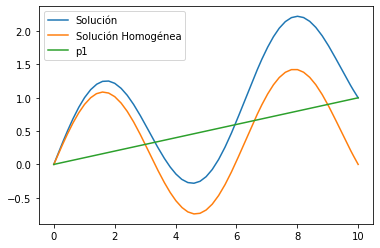

In [11]:
p = lambda x:1.0;    q = lambda x:0.0;
resolver_autoadjunto(p=p, q=q, f=lambda z:sp.sin(z), ya=0, yb=1);

Detectadas condiciones tipo neumann_derecha

Matriz de rigidez:

[[10. -5.  0. ...  0.  0.  0.]
 [-5. 10. -5. ...  0.  0.  0.]
 [ 0. -5. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 10. -5.  0.]
 [ 0.  0.  0. ... -5. 10. -5.]
 [ 0.  0.  0. ...  0. -5.  5.]]

Vector de carga:

[ 0.0396016   0.0776244   0.11255257  0.14299362  0.16773396  0.18578729
  0.19643385  0.19924923  0.19412116  0.18125409  0.161161    0.13464293
  0.10275706  0.0667746   0.02813005 -0.01163596 -0.05093809 -0.08820947
 -0.12196422 -0.15085664 -0.17373488 -0.18968686 -0.19807662 -0.1985697
 -0.19114642 -0.17610275 -0.15403841 -0.12583304 -0.09261111 -0.05569707
 -0.01656256  0.02323225  0.06210086  0.0984937   0.13095991  0.15820517
  0.17914328  0.19293951  0.19904386  0.19721296  0.18751979  0.17035081
  0.14639047  0.11659401  0.08214932  0.04442959  0.00493859 -0.03474929
 -0.07305183 -0.04863838]


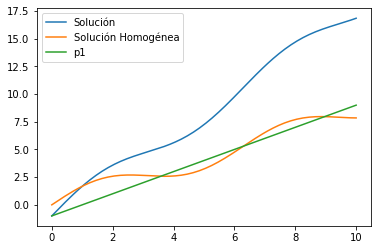

In [12]:
p = lambda x:1.0;    q = lambda x:0.0;
resolver_autoadjunto(p=p, q=q, f=lambda z:sp.sin(z), ya=-1, dyb=1);

Obtenemos los mismos resultados que en los ejemplos vistos en clase. Probamos con otros problemas, esta vez con $p$ y $q$ no constantes.

Detectadas condiciones tipo dirichlet

Matriz de rigidez:

[[10. -5.  0. ...  0.  0.  0.]
 [-5. 10. -5. ...  0.  0.  0.]
 [ 0. -5. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 10. -5.  0.]
 [ 0.  0.  0. ... -5. 10. -5.]
 [ 0.  0.  0. ...  0. -5. 10.]]

Vector de carga:

[ 0.0436016   0.0856244   0.12455257  0.15899362  0.18773396  0.20978729
  0.22443385  0.23124923  0.23012116  0.22125409  0.205161    0.18264293
  0.15475706  0.1227746   0.08813005  0.05236404  0.01706191 -0.01620947
 -0.04596422 -0.07085664 -0.08973488 -0.10168686 -0.10607662 -0.1025697
 -0.09114642 -0.07210275 -0.04603841 -0.01383304  0.02338889  0.06430293
  0.10743744  0.15123225  0.19410086  0.2344937   0.27095991  0.30220517
  0.32714328  0.34493951  0.35504386  0.35721296  0.35151979  0.33835081
  0.31839047  0.29259401  0.26214932  0.22842959  0.19293859  0.15725071
  0.12294817]


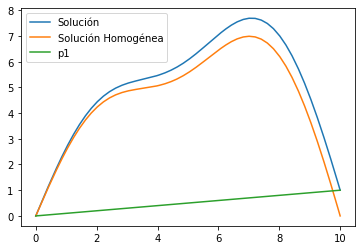

In [13]:
p = lambda x:x**2;    q = lambda x:1.0;
resolver_autoadjunto(p=p, q=q, f=lambda z:sp.sin(z), ya=0.0, yb=1.0);

Detectadas condiciones tipo neumann_izquierda

Matriz de rigidez:

[[ 5. -5.  0. ...  0.  0.  0.]
 [-5. 10. -5. ...  0.  0.  0.]
 [ 0. -5. 10. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 10. -5.  0.]
 [ 0.  0.  0. ... -5. 10. -5.]
 [ 0.  0.  0. ...  0. -5. 10.]]

Vector de carga:

[-0.01721119 -0.0479964  -0.05025018 -0.04765213 -0.0463365  -0.04793953
 -0.05257006 -0.05972762 -0.06875151 -0.07902905 -0.09006939 -0.10151082
 -0.11310151 -0.12467397 -0.13612164 -0.14738028 -0.15841412 -0.16920614
 -0.17975131 -0.19005202 -0.2001151  -0.20994979 -0.21956657 -0.22897627
 -0.23818965 -0.24721709 -0.25606845 -0.26475299 -0.27327935 -0.28165557
 -0.2898891  -0.29798686 -0.30595525 -0.31380022 -0.3215273  -0.3291416
 -0.33664791 -0.34405069 -0.3513541  -0.35856202 -0.3656781  -0.37270577
 -0.37964824 -0.38650854 -0.3932895  -0.39999383 -0.40662407 -0.41318261
 -0.41967173 -0.4260936 ]


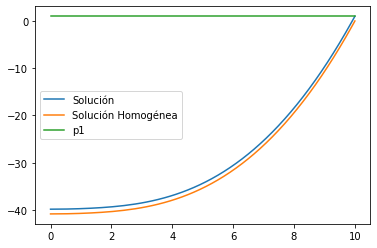

In [14]:
p = lambda x:sp.cos(x);    q = lambda x:sp.sqrt(x);
sol = resolver_autoadjunto(p=p, q=q, f=lambda z:sp.tanh(z), dya=0.0, yb=1.0);

In [15]:
# Comprobamos que se cumplen las condiciones de contorno
(sol[1]-sol[0])/(x[1]-x[0]), sol[-1]

(0.000861420945135194, 1.0)

En los dos ejemplo anteriores obtenemos soluciones que satisfacen las condiciones de contorno impuestas, a pesar de haber usado funciones $p,q$ y $f$ más complejas.